AutoEncoder-based Anomaly Detection

In [159]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


In [160]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [161]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),lambda x: x.view(-1)])
root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

magic_num = 3 #magic_numのみを学習させる．

train_indices = [i for i, label in enumerate(mnist_train.targets) if label == magic_num]
mnist_train_0 = Subset(mnist_train, train_indices)

test_labels = mnist_test.targets
idx_0 = (test_labels == magic_num).nonzero(as_tuple=True)[0]
idx_not0 = (test_labels != magic_num).nonzero(as_tuple=True)[0]
half_len = min(len(idx_0),len(idx_not0))
selected_idx_0 = idx_0[:half_len]
selected_idx_not0 = idx_not0[:half_len]
combined_indices = torch.cat([selected_idx_0, selected_idx_not0])
mnist_test_balanced = Subset(mnist_test, combined_indices)

In [162]:
def get_new_dataloader(mnist_train,mnist_test,batch_size):

    train_dataloader = DataLoader(mnist_train,batch_size,shuffle=True)
    test_dataloader = DataLoader(mnist_test,batch_size,shuffle=False)
    return train_dataloader, test_dataloader

In [163]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [164]:
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)#<<<<<<<<<<<<<<<<<<<<<<
        self.alpha.requires_grad = False#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def forward(self, x):
        b, n_patches,  k, _ = x.shape
        x = x.reshape(b*n_patches, -1)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T 
        x = torch.abs(x)**2 
        return x

In [165]:
#EncoderLI
class Encoder1(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder1, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        kernel_in = int(channels*kernel_size**2)

        self.B = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))#.to(device)
        self.B.requires_grad = False
    def forward(self, x):
        b, n_patches, k, _ = x.shape
        x = x.view(b*n_patches, -1) 
        x = x.T
        x = torch.matmul(self.B,x)
        x = x.T
        return x

In [166]:
class MLP(nn.Module):
    def __init__(self, potential_dim, out_dim):
        super(MLP,self).__init__()

        mid1 = int((potential_dim+out_dim)/2)
        self.fc1 = nn.Linear(potential_dim,mid1)
        self.fc2 = nn.Linear(mid1, out_dim)
        self.func = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return x

In [167]:
class AutoEncoder(nn.Module):
    def __init__(self,img_size,channels, kernel_size,leverage):
        super(AutoEncoder, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = channels*kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        potential_dim = num_patches * feat_dim
        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.bn = nn.BatchNorm1d(feat_dim)
        self.decoder =  MLP(potential_dim,img_size**2*channels)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = self.split(x, self.kernel_size) 
        x = self.encoder(x) 
        x = self.bn(x)
        x = x.reshape(b, -1)
        x = self.decoder(x)
        return x


1/5th Time Epoch: 10/10

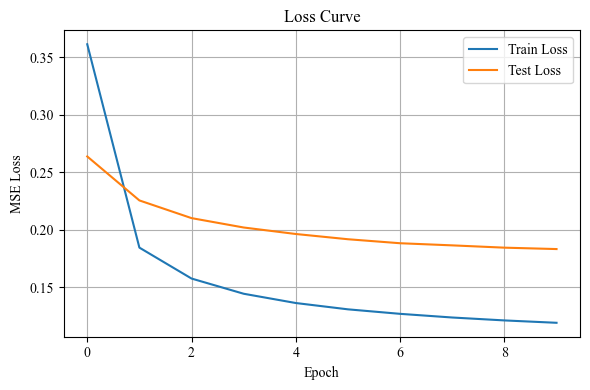

ROC AUC: 0.9390


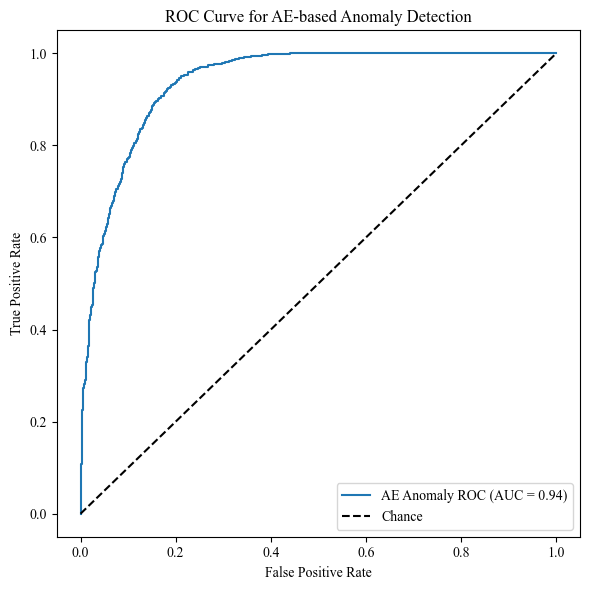


ROC AUC: 0.9390
Best F1: 0.8787 @ Threshold = 0.145408


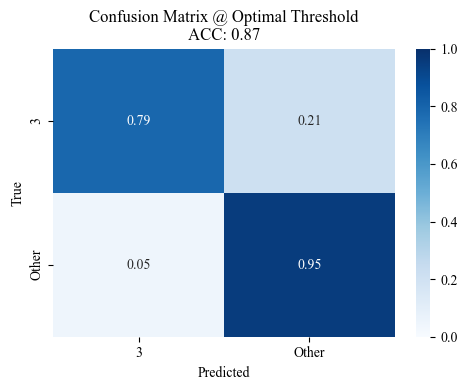

2/5th Time Epoch: 10/10

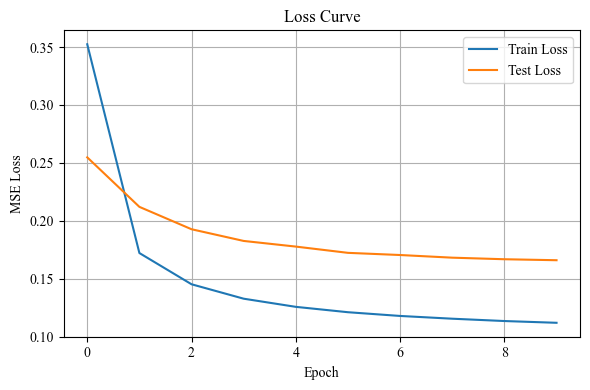

ROC AUC: 0.9466


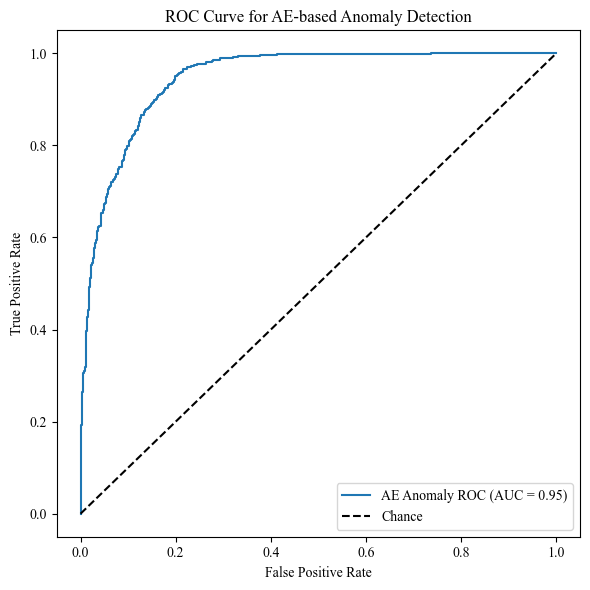


ROC AUC: 0.9466
Best F1: 0.8847 @ Threshold = 0.130755


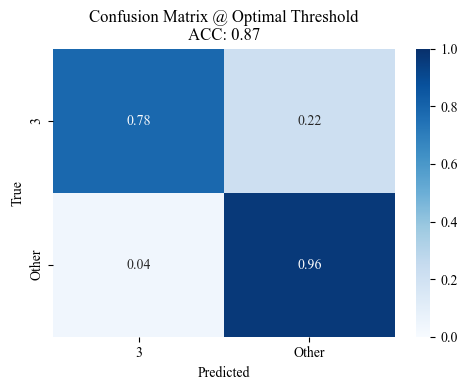

3/5th Time Epoch: 10/10

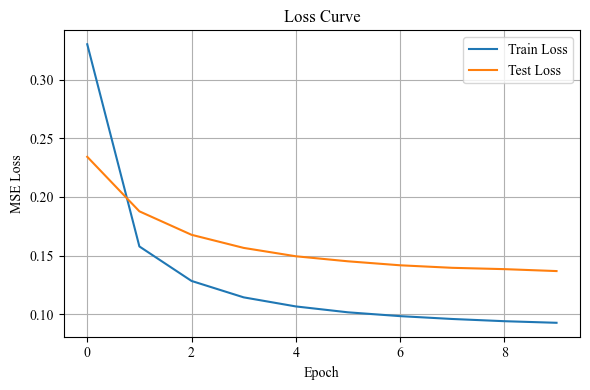

ROC AUC: 0.9307


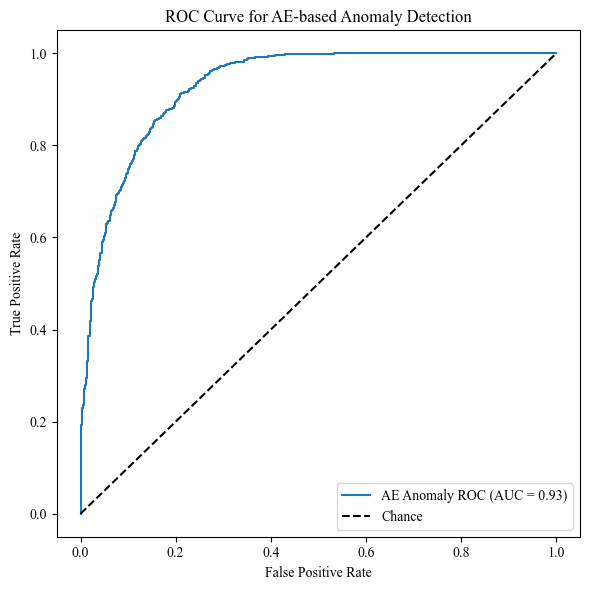


ROC AUC: 0.9307
Best F1: 0.8603 @ Threshold = 0.105096


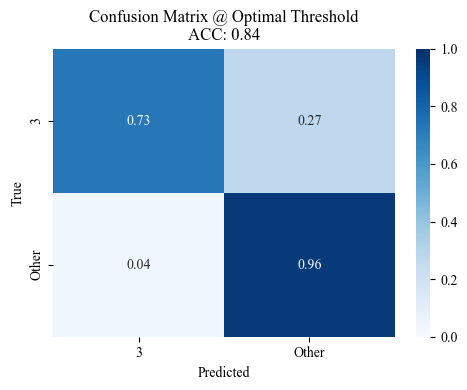

4/5th Time Epoch: 10/10

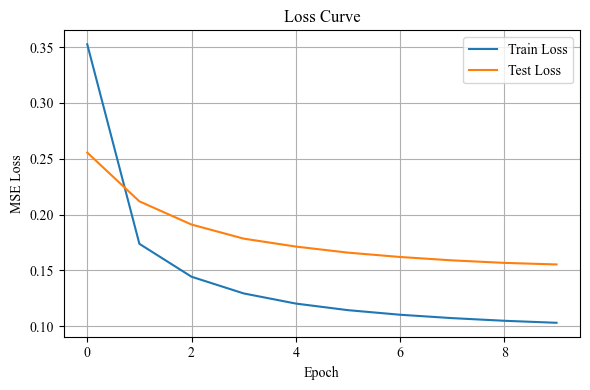

ROC AUC: 0.9375


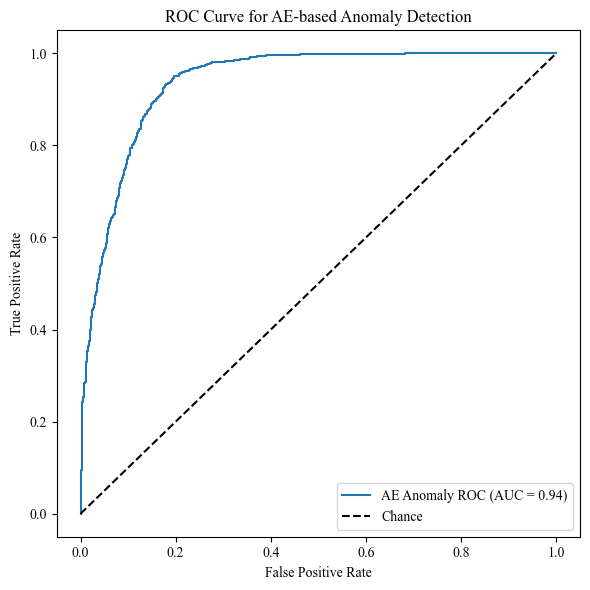


ROC AUC: 0.9375
Best F1: 0.8851 @ Threshold = 0.125335


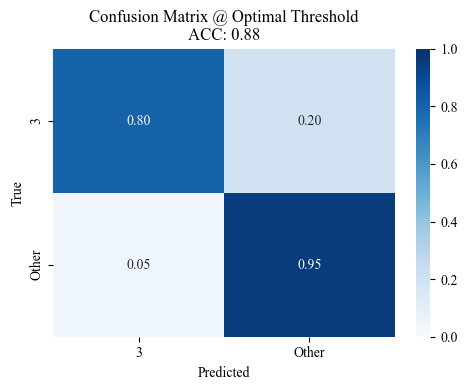

5/5th Time Epoch: 10/10

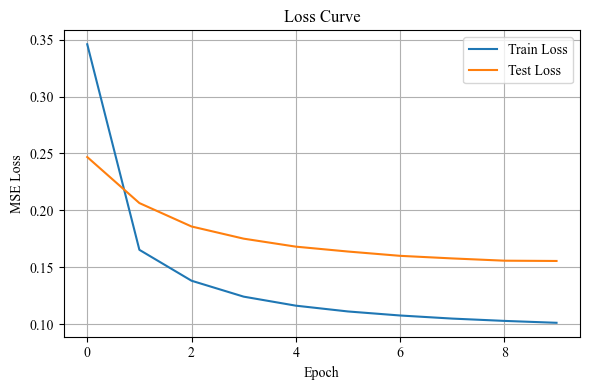

ROC AUC: 0.9300


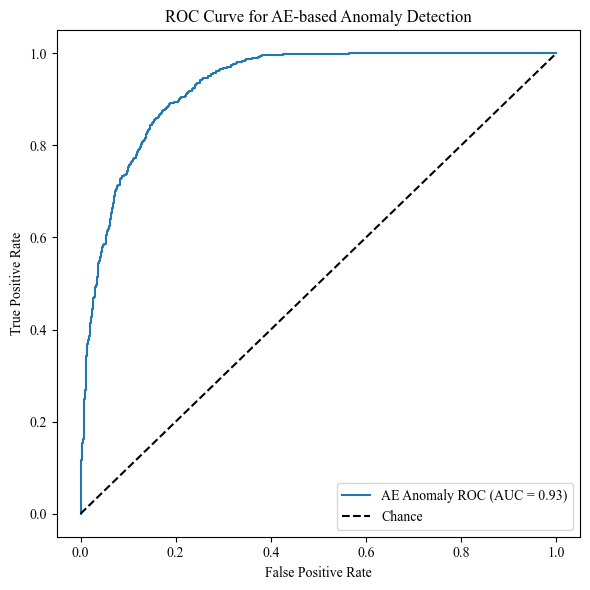


ROC AUC: 0.9300
Best F1: 0.8587 @ Threshold = 0.115983


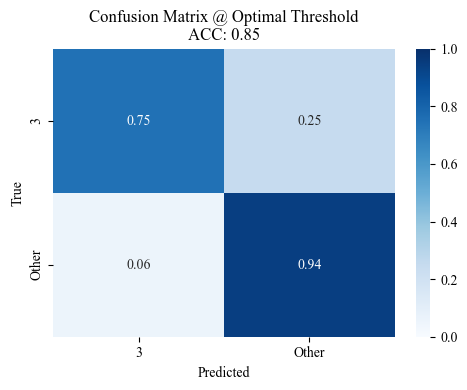

In [168]:
channels = 1
img_size = 28
leverage = 8
kernel_size = 4
batch_size = 64

input_dim = channels*img_size**2
max_epochs = 10
lr = 1e-4 #学習率
batch_size = 32

num_try = 5 #

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_auc = []
All_best_acc = []

for num_times in range(num_try): 
    train_dataloader, test_dataloader = get_new_dataloader(mnist_train_0,mnist_test_balanced,batch_size)
    #print(next(iter(train_dataloader)))
    model = AutoEncoder(img_size,channels,kernel_size,leverage).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs))
        sys.stderr.flush()

        start_time1 = time.time()
        for (batch_X,_) in train_dataloader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_X.view(batch_X.size(0), -1))
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        mse_scores  = []
        true_labels = []
        with torch.no_grad():
            test_loss = 0.0
            for batch_x, batch_y in test_dataloader:
                batch_x = batch_x.to(device)
                outputs = model(batch_x).to(device)
                loss = criterion(outputs, batch_x.view(batch_x.size(0), -1))
                test_loss += loss.item()
                batch_mse = ((outputs - batch_x.view(batch_x.size(0), -1)) ** 2).mean(dim=1)
                mse_scores.extend(batch_mse.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())
            test_loss /= len(test_dataloader)
            loss_test_.append(test_loss)

    plt.figure(figsize=(6,4))
    plt.plot(loss_train_, label="Train Loss")
    plt.plot(loss_test_, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    binary_labels = [0 if y == magic_num else 1 for y in true_labels]
    fpr, tpr, thresholds = roc_curve(binary_labels, mse_scores)
    roc_auc = auc(fpr, tpr)
    All_test_auc.append(roc_auc)
    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AE Anomaly ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")#正常のサンプルのうち間違って異常と検出した割合
    plt.ylabel("True Positive Rate")#異常のサンプルのうち異常と正しく判定をした割合
    plt.title("ROC Curve for AE-based Anomaly Detection")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    best_f1 = 0
    best_th = None
    for th in thresholds:
        preds = (np.array(mse_scores) > th).astype(int)
        f1 = f1_score(binary_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    print(f"\nROC AUC: {roc_auc:.4f}")
    print(f"Best F1: {best_f1:.4f} @ Threshold = {best_th:.6f}")

    #── 混同行列（最適閾値に基づく2値分類）──
    y_pred = (np.array(mse_scores) > best_th).astype(int)
    cm = confusion_matrix(binary_labels, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    accuracy = accuracy_score(binary_labels, y_pred)
    All_best_acc.append(accuracy)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"{magic_num}", "Other"], 
                yticklabels=[f"{magic_num}", "Other"],vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix @ Optimal Threshold\nACC: {accuracy:.2f}")
    plt.tight_layout()
    plt.show()


In [169]:
ACC_mean = np.mean(All_best_acc)
ACC_best = np.max(All_best_acc)
ACC_bestID = np.argmax(All_best_acc)+1
ACC_worst = np.min(All_best_acc)
ACC_worstID = np.argmin(All_best_acc)+1

AUC_mean = np.mean(All_test_auc)
AUC_best = np.max(All_test_auc)
AUC_bestID = np.argmax(All_test_auc)+1
AUC_worst = np.min(All_test_auc)
AUC_worstID = np.argmin(All_test_auc)+1

data = {
        "": ["Best ACC", "AUC"],
    "Average": [ACC_mean,AUC_mean],
    "Best ID": [ACC_bestID,AUC_bestID],
    "Best": [ACC_best,AUC_best],
    "Worst ID": [ACC_worstID,AUC_worstID],
    "Worst": [ACC_worst,AUC_worst],
}

df = pd.DataFrame(data)

print(df)

              Average  Best ID      Best  Worst ID     Worst
0  Best ACC  0.861782        4  0.876733         3  0.844059
1       AUC  0.936750        2  0.946563         5  0.930018
